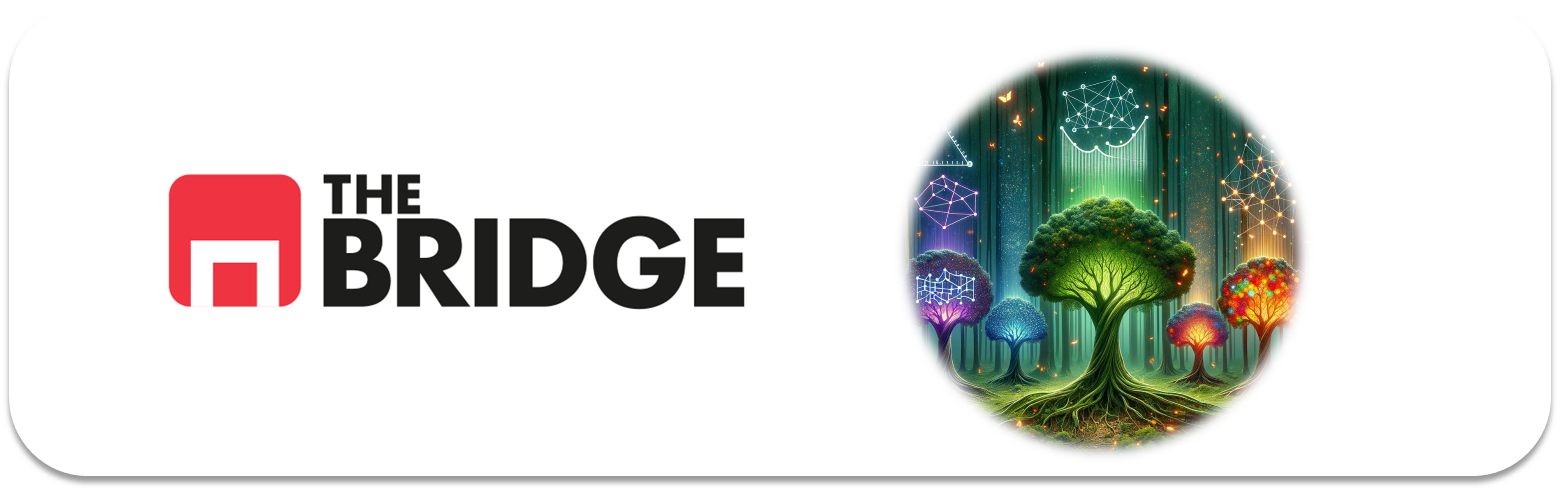

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

In [2]:
# ==============================
# 1. CARGA Y LIMPIEZA DE DATOS
# ==============================
file_path = r"C:\Users\anton\SUBIR_EJERCICIOS_THEBRIDGE\EJERCICIOS_THEBRIDGE\Sprint-11\Obligatoria 1\data\bank-full.csv"

df_bank = pd.read_csv(file_path, sep=";", engine='python')




In [3]:
# Convertir el target a valores numéricos
df_bank['y'] = df_bank['y'].map({'no': 0, 'yes': 1})

# Identificar valores nulos
print("Valores nulos por columna:\n", df_bank.isnull().sum())

Valores nulos por columna:
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [4]:
print(df_bank.columns)


Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')



Distribución del target:
 y
0    0.883015
1    0.116985
Name: proportion, dtype: float64


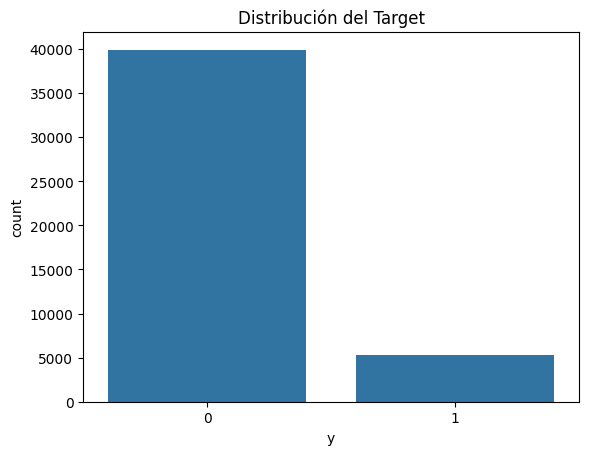

In [5]:

# 2. ANÁLISIS EXPLORATORIO Y DISTRIBUCIONES
print("\nDistribución del target:\n", df_bank['y'].value_counts(normalize=True))

# Graficar la distribución del target
sns.countplot(x=df_bank['y'])
plt.title("Distribución del Target")
plt.show()


In [6]:

# 3. TRANSFORMACIÓN Y SELECCIÓN DE VARIABLES


# Aplicar Label Encoding a variables categóricas
categorical_columns = df_bank.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_bank[col] = le.fit_transform(df_bank[col])
    label_encoders[col] = le

# Manejo de la variable "pdays"
df_bank['previous_contact'] = (df_bank['pdays'] != -1).astype(int)
df_bank.drop(columns=['pdays'], inplace=True)


In [7]:


# 4. DIVISIÓN DE DATOS Y ESCALADO

# Separar variables predictoras y target
X = df_bank.drop(columns=['y'])
y = df_bank['y']

# División de datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalar variables numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:

# 5. PRIMEROS ENTRENAMIENTOS (BASELINE)


# Modelo baseline: Regresión Logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

# Evaluación inicial de la regresión logística
print("\nEvaluación de la Regresión Logística:")
print(classification_report(y_test, y_pred_log))


Evaluación de la Regresión Logística:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7985
           1       0.65      0.31      0.42      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.68      9043
weighted avg       0.88      0.90      0.88      9043



In [9]:
# 6. OPTIMIZACIÓN Y MEJOR MODELO DE ÁRBOL DE DECISIÓN

# Definir el modelo base de árbol de decisión
tree_model = DecisionTreeClassifier(random_state=42)

# Definir el grid de hiperparámetros para optimización
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}


# Configurar GridSearchCV
grid_search = GridSearchCV(tree_model, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)

# Ejecutar la optimización
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
best_tree_model = grid_search.best_estimator_
print("\nMejores hiperparámetros del Árbol de Decisión:", grid_search.best_params_)



Fitting 5 folds for each of 72 candidates, totalling 360 fits

Mejores hiperparámetros del Árbol de Decisión: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [ ]:
# Modelo base: Árbol de Decisión sin optimización
base_tree = DecisionTreeClassifier(random_state=42)
base_tree.fit(X_train, y_train)
y_pred_base = base_tree.predict(X_test)

# Evaluación del modelo base
print("\nEvaluación del Modelo Base (Árbol de Decisión sin optimizar):")
print(classification_report(y_test, y_pred_base))

# Matriz de confusión - Modelo Base
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_base), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión - Modelo Base (Árbol de Decisión)")
plt.show()


Fitting 5 folds for each of 72 candidates, totalling 360 fits

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}

Evaluación del Modelo Optimizado (Árbol de Decisión con GridSearchCV):
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      7985
           1       0.57      0.42      0.49      1058

    accuracy                           0.90      9043
   macro avg       0.75      0.69      0.71      9043
weighted avg       0.88      0.90      0.89      9043



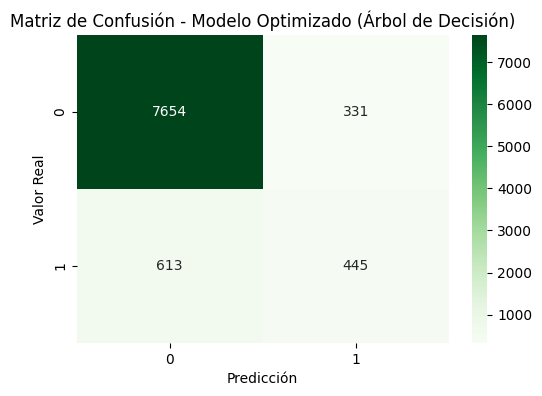

In [ ]:
# Definir hiperparámetros para GridSearchCV
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}

# Optimización con GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Mejor modelo optimizado
best_tree_model = grid_search.best_estimator_
print("\nMejores hiperparámetros:", grid_search.best_params_)

# Predicciones con el modelo optimizado
y_pred_optimized = best_tree_model.predict(X_test)

# Evaluación del modelo optimizado
print("\nEvaluación del Modelo Optimizado (Árbol de Decisión con GridSearchCV):")
print(classification_report(y_test, y_pred_optimized))

# Matriz de confusión - Modelo Optimizado
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_optimized), annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión - Modelo Optimizado (Árbol de Decisión)")
plt.show()



Comparación de Métricas:
Accuracy - Árbol de Decisión: 0.8956098639831914
F1 Score - Árbol de Decisión: 0.48527808069792805
Accuracy - Regresión Logística: 0.900364923144974
F1 Score - Regresión Logística: 0.42428115015974444


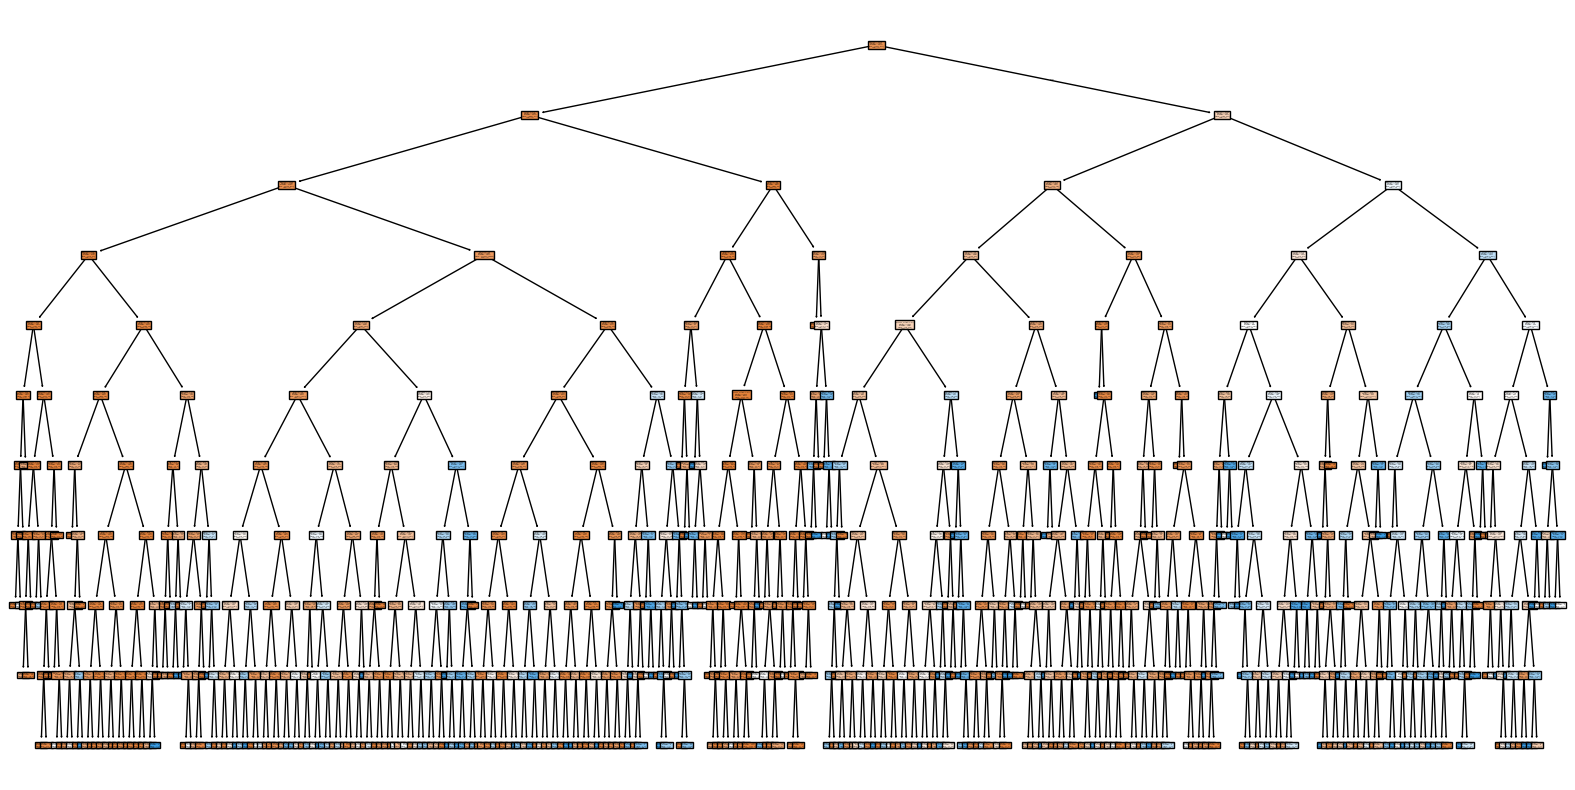

In [ ]:
# ==============================
# 8. COMPARACIÓN DE MODELOS
# ==============================

print("\nComparación de Métricas:")
print("Accuracy - Árbol de Decisión:", accuracy_score(y_test, y_pred_tree))
print("F1 Score - Árbol de Decisión:", f1_score(y_test, y_pred_tree))
print("Accuracy - Regresión Logística:", accuracy_score(y_test, y_pred_log))
print("F1 Score - Regresión Logística:", f1_score(y_test, y_pred_log))

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(best_tree_model, filled=True, feature_names=X.columns, class_names=["No", "Yes"])
plt.show()

